Posterior mean of theta: 10.17541223888176
Posterior mean of tau: 0.26050652571754607


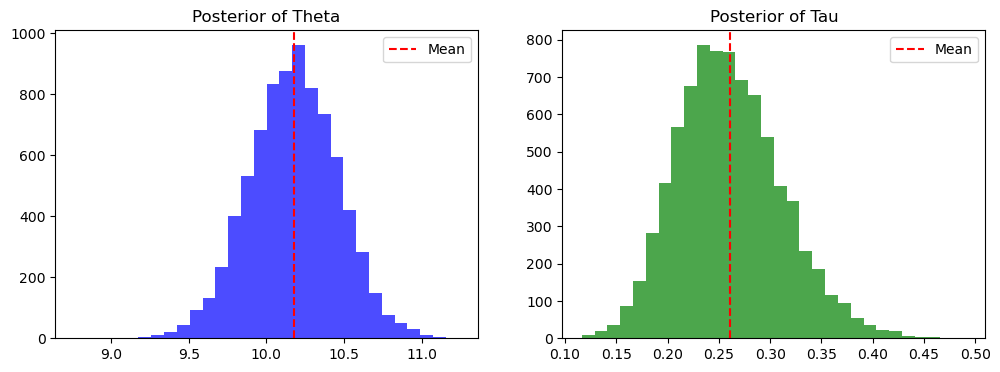

In [3]:
#Q1
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def gibbs_sampling_normal(data, n_iter, burn_in):
    """
    Gibbs sampling for Normal(mean=theta, precision=tau)

    Args:
        data (array): Observed data
        n_iter (int): Number of iterations
        burn_in (int): Burn-in period

    Returns:
        theta_samples, tau_samples: Posterior samples after burn-in
    """
    n = len(data)
    x_mean = np.mean(data)
    x_sum_sq = np.sum((data - x_mean)**2)

    # Storage for samples
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    theta_current = np.random.normal(loc=0, scale=1)
    tau_current = np.random.gamma(shape=2, scale=1)

    for t in range(n_iter):
        # Sample tau given theta and data
        shape = n / 2 + 1
        rate = 0.5 * x_sum_sq + 0.5 * n * (theta_current - x_mean)**2
        tau_current = np.random.gamma(shape=shape, scale=1/rate)

        # Sample theta given tau and data
        variance_theta = 1 / (n * tau_current)
        mean_theta = x_mean
        theta_current = np.random.normal(loc=mean_theta, scale=np.sqrt(variance_theta))

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

# Example usage
data = np.random.normal(10, 2, size=50)  # Generate simulated data
n_iter = 10000  # Total number of iterations
burn_in = 2000  # Burn-in period

theta_samples, tau_samples = gibbs_sampling_normal(data, n_iter, burn_in)

# Analyze results
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau:", np.mean(tau_samples))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Theta posterior
ax[0].hist(theta_samples, bins=30, color='blue', alpha=0.7)
ax[0].axvline(np.mean(theta_samples), color='red', linestyle='--', label='Mean')
ax[0].set_title('Posterior of Theta')
ax[0].legend()

# Tau posterior
ax[1].hist(tau_samples, bins=30, color='green', alpha=0.7)
ax[1].axvline(np.mean(tau_samples), color='red', linestyle='--', label='Mean')
ax[1].set_title('Posterior of Tau')
ax[1].legend()

plt.show()


Iteration 0: theta_current=49.98624804051362, tau_current=0.1833285111531867
Iteration 1000: theta_current=43.32309279128602, tau_current=1.5429720477553686
Iteration 2000: theta_current=39.927498042982954, tau_current=0.7919338628688105
Iteration 3000: theta_current=36.98370616661226, tau_current=4.107742415717382
Iteration 4000: theta_current=31.909051785009016, tau_current=0.8916874734460938
Iteration 5000: theta_current=26.91225405662092, tau_current=0.32829882267739807
Iteration 6000: theta_current=21.947640316566304, tau_current=0.0683936968876782
Iteration 7000: theta_current=23.355238539339993, tau_current=0.11701592679693201
Iteration 8000: theta_current=14.242075497683718, tau_current=1.2630741947828774
Iteration 9000: theta_current=9.123007636323486, tau_current=0.664529322812995
Posterior mean of theta: 23.363904080919486
Posterior mean of tau: 0.9370726196199827


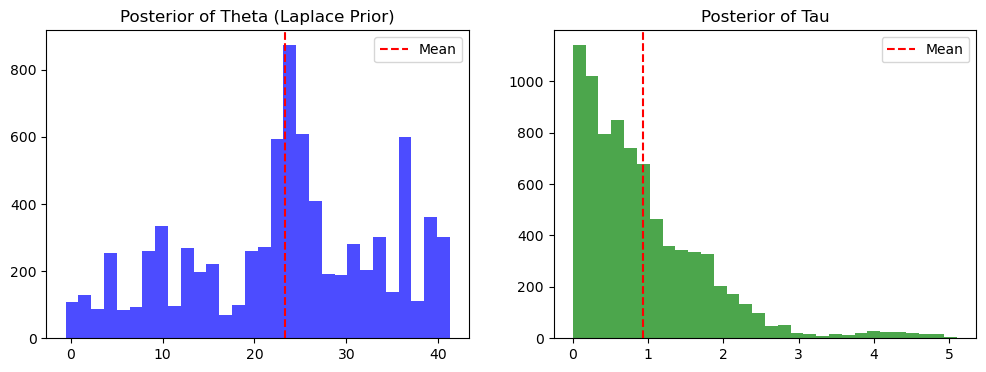

In [8]:
#Q2
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# HW4 Question 2: Metropolis-Hastings with Laplace Prior for Theta

def metropolis_hastings_laplace(data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta, prop_sd_tau):
    """
    Metropolis-Hastings within Gibbs sampling for Normal(mean=theta, precision=tau)
    with Laplace prior on theta.

    Args:
        data (array): Observed data
        theta0 (float): Initial value for theta
        tau0 (float): Initial precision for theta
        alpha (float): Shape parameter for Gamma prior on tau
        lam (float): Rate parameter for Gamma prior on tau
        n_iter (int): Number of iterations
        burn_in (int): Burn-in period
        prop_sd_theta (float): Proposal standard deviation for theta
        prop_sd_tau (float): Proposal standard deviation for tau

    Returns:
        theta_samples, tau_samples: Posterior samples after burn-in
    """
    data = np.asarray(data)
    n = len(data)
    x_mean = np.mean(data)
    x_sum_sq = np.sum((data - x_mean)**2)

    # Storage for samples
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    theta_current = theta0
    tau_current = tau0

    for t in range(n_iter):
        # ----------------------------
        # Step 1: Metropolis update for theta
        # ----------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        # Compute acceptance ratio
        prior_current_theta = stats.laplace.pdf(theta_current, scale=1/lam)
        prior_proposed_theta = stats.laplace.pdf(theta_proposed, scale=1/lam)

        likelihood_current = max(stats.norm.pdf(data, loc=theta_current, scale=1/np.sqrt(tau_current)).prod(), 1e-10)
        likelihood_proposed = max(stats.norm.pdf(data, loc=theta_proposed, scale=1/np.sqrt(tau_current)).prod(), 1e-10)

        p_current_theta = likelihood_current * prior_current_theta
        p_proposed_theta = likelihood_proposed * prior_proposed_theta

        acceptance_ratio_theta = p_proposed_theta / p_current_theta

        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed

        # ----------------------------
        # Step 2: Metropolis update for tau
        # ----------------------------
        a, b = 0, np.inf  # Bounds for truncated normal
        s = prop_sd_tau
        tau_proposed = stats.truncnorm.rvs(
            (a - tau_current) / s, (b - tau_current) / s, loc=tau_current, scale=s
        )

        # Compute acceptance ratio
        prior_current_tau = stats.gamma.pdf(tau_current, a=alpha, scale=1/lam)
        prior_proposed_tau = stats.gamma.pdf(tau_proposed, a=alpha, scale=1/lam)

        likelihood_current_tau = max(stats.norm.pdf(data, loc=theta_current, scale=1/np.sqrt(tau_current)).prod(), 1e-10)
        likelihood_proposed_tau = max(stats.norm.pdf(data, loc=theta_current, scale=1/np.sqrt(tau_proposed)).prod(), 1e-10)

        p_current_tau = likelihood_current_tau * prior_current_tau
        p_proposed_tau = likelihood_proposed_tau * prior_proposed_tau

        acceptance_ratio_tau = (p_proposed_tau / p_current_tau) * \
                               (stats.truncnorm.pdf(tau_current, (a - tau_proposed) / s, (b - tau_proposed) / s, loc=tau_proposed, scale=s) / \
                                stats.truncnorm.pdf(tau_proposed, (a - tau_current) / s, (b - tau_current) / s, loc=tau_current, scale=s))

        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

        # Debugging output for diagnostics
        if t % 1000 == 0:
            print(f"Iteration {t}: theta_current={theta_current}, tau_current={tau_current}")

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

# Example usage
data = np.random.normal(10, 2, size=50)  # Simulated data

theta0 = 50  # Prior mean for theta
tau0 = 1/25  # Initial precision for tau
alpha = 1.0  # Shape parameter for Gamma prior
lam = 1.0  # Rate parameter for Gamma prior
n_iter = 10000  # Number of iterations
burn_in = 2000  # Burn-in period
prop_sd_theta = 0.1  # Proposal standard deviation for theta
prop_sd_tau = 0.1  # Proposal standard deviation for tau

theta_samples, tau_samples = metropolis_hastings_laplace(
    data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta, prop_sd_tau
)

# Analyze results
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau:", np.mean(tau_samples))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Theta posterior
ax[0].hist(theta_samples, bins=30, color='blue', alpha=0.7)
ax[0].axvline(np.mean(theta_samples), color='red', linestyle='--', label='Mean')
ax[0].set_title('Posterior of Theta (Laplace Prior)')
ax[0].legend()

# Tau posterior
ax[1].hist(tau_samples, bins=30, color='green', alpha=0.7)
ax[1].axvline(np.mean(tau_samples), color='red', linestyle='--', label='Mean')
ax[1].set_title('Posterior of Tau')
ax[1].legend()

plt.show()


### Question 3: Explanation and Derivation

#### Problem Description:
In this question, we derive and explain the Metropolis-Hastings algorithm for a Bayesian inference problem where the posterior distribution is challenging to compute directly. Specifically, we:

1. Explain the foundation of the Metropolis-Hastings algorithm.
2. Derive the acceptance ratio for a simple binary state space.
3. Provide detailed steps to calculate the transition matrix and verify the stationary distribution.

---

#### Part 1: Theoretical Foundation of Metropolis-Hastings
The Metropolis-Hastings (MH) algorithm is a Markov Chain Monte Carlo (MCMC) method that generates samples from a target distribution $$p(x)$$. The key idea is to construct a Markov chain with a stationary distribution matching the target distribution.

**Steps of the MH Algorithm:**
1. **Initialization:** Start with an initial state $x_0$.
2. **Proposal Step:** Propose a new state $\tilde{x}$ using a proposal distribution $q(\tilde{x} \mid x)$.
3. **Acceptance Step:** Compute the acceptance probability:
   $
   \alpha(x \to \tilde{x}) = \min\left(1, \frac{p(\tilde{x}) q(x \mid \tilde{x})}{p(x) q(\tilde{x} \mid x)}\right).
   $
   If the proposal is accepted, set $x_{t+1} = \tilde{x}$; otherwise, set $x_{t+1} = x_t$.
4. **Repeat:** Iterate the proposal and acceptance steps to generate a Markov chain.

---

#### Part 2: Derivation for Binary State Space

**Problem Setup:**
We consider a binary state space $x \in \{0, 1\}$ with the following probabilities:
- $p(0) = 1/3$
- $p(1) = 2/3$.

We use a symmetric proposal distribution:
$
q(\tilde{x} \mid x) = \begin{cases} 
0.5 & \text{if } \tilde{x} \neq x, \\
0 & \text{if } \tilde{x} = x.
\end{cases}
$
Since $q(\tilde{x} \mid x) = q(x \mid \tilde{x})$, the acceptance probability simplifies to:
$
\alpha(x \to \tilde{x}) = \min\left(1, \frac{p(\tilde{x})}{p(x)}\right).
$

**Acceptance Ratios:**
1. If $x = 0$ and $\tilde{x} = 1$:
   $
   \alpha(0 \to 1) = \min\left(1, \frac{p(1)}{p(0)}\right) = \min\left(1, \frac{2/3}{1/3}\right) = 1.
   $
2. If $x = 1$ and $\tilde{x} = 0$:
   $
   \alpha(1 \to 0) = \min\left(1, \frac{p(0)}{p(1)}\right) = \min\left(1, \frac{1/3}{2/3}\right) = 0.5.
   $

---

#### Part 3: Transition Matrix and Stationary Distribution
Using the acceptance probabilities, we construct the transition matrix $$K$$:
$
K = \begin{bmatrix}
K(0 \to 0) & K(0 \to 1) \\
K(1 \to 0) & K(1 \to 1)
\end{bmatrix} = \begin{bmatrix}
0.5 & 0.5 \\
0.25 & 0.75
\end{bmatrix}.
$

Here:
- $K(0 \to 0) = 1 - \alpha(0 \to 1) = 0.5$.
- $K(0 \to 1) = \alpha(0 \to 1) = 0.5$.
- $K(1 \to 0) = \alpha(1 \to 0) \cdot q(0 \mid 1) = 0.25$.
- $K(1 \to 1) = 1 - K(1 \to 0) = 0.75$.

**Stationary Distribution Verification:**
Let $\pi = [\pi_0, \pi_1]$ be the stationary distribution. Solving $\pi K = \pi$, we have:
$
\begin{aligned}
\pi_0 K(0 \to 0) + \pi_1 K(1 \to 0) &= \pi_0, \\
\pi_0 K(0 \to 1) + \pi_1 K(1 \to 1) &= \pi_1.
\end{aligned}
$
Substituting $\pi_0 + \pi_1 = 1$:
$
\pi_0 = 1/3, \quad \pi_1 = 2/3.
$
This matches the target distribution $p(0) = 1/3, p(1) = 2/3$.

---

#### Part 4: Intuition and Conclusion
- **Why it works:** The Metropolis-Hastings algorithm ensures the chain spends more time in states with higher posterior probabilities, approximating the target distribution.
- **Detailed balance:** The symmetry of $q$ and the acceptance probabilities guarantee detailed balance, leading to the correct stationary distribution.

This approach demonstrates how to derive and verify the algorithm for a simple binary state space. The methodology extends naturally to more complex problems.
